# Heurísticas Construtivas aplicadas ao TSP

**Desenvolvedor**: Vítor Gabriel Reis Caitité 

In [1]:
# Imports
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import sqrt
import time 
from matplotlib.animation import FuncAnimation
from random import choice
import time
import copy

## Função para cálculo da matrix de distâncias

In [2]:
# Cálculo da matrix de distâncias considerando a distância euclideana
def calculate_euc_distance_matrix(data):
    d = np.zeros((data.shape[0], data.shape[0])) # distance matrix
    for l in range(0, data.shape[0]):
        for c in range(0, data.shape[0]):
            d[l, c] = sqrt(sum((data[l] - data[c])**2))
    return d

# Cálculo da matrix de distâncias considerando a distância pseudo-euclideana
def calculate_pseudo_euc_distance_matrix(data):
    d = np.zeros((data.shape[0], data.shape[0])) # distance matrix
    for l in range(0, data.shape[0]):
        for c in range(0, data.shape[0]):
            rij = sqrt(sum((data[l] - data[c])**2)/10.0)
            tij = round(rij)
            if tij < rij:
                dij = tij + 1
            else:
                dij = tij
            d[l, c] = dij
    return d

### Exemplo de matrix de distâncias para o problema berlin52

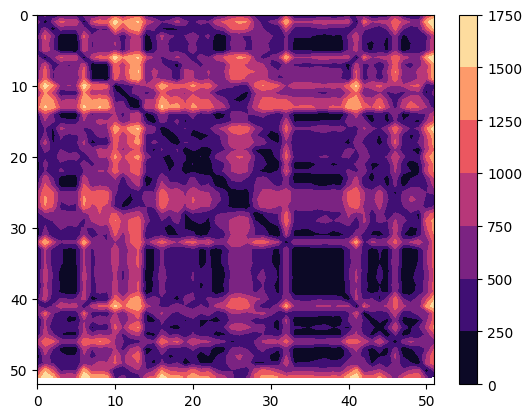

In [3]:
df = pd.read_csv('~/Documents/UFMG/Mastering/3/Heurística_Meta-heurística/TPs/heuristics-and-metaheuristics/instances/EUC_2D/berlin52.tsp', skiprows=range(0, 6), sep='\s+',                       names=["X", "Y"], header=None) 
data = df.drop(df.tail(1).index, axis=0).to_numpy()
d = calculate_euc_distance_matrix(data)
plt.contourf(d, cmap='magma')
plt.ylim([data.shape[0], 0])
plt.colorbar()

# Function to generate a gif

In [5]:
# Gif generator
def gif_generator(X, paths, arq_name):
    
    def update(i):
        path = paths[i]
        ax.clear()
        ax.scatter(X[:, 0], X[:, 1], cmap='viridis', edgecolors='k', linewidths=1.6)
        for j in range(len(path)-1):
            x_values = [X[path[j], 0], X[path[j+1], 0]]
            y_values = [X[path[j], 1], X[path[j+1], 1]]
            ax.plot(x_values, y_values, 'black', linestyle="-")
        return ax

    fig, ax = plt.subplots(figsize=(6,5,))
    fig.set_tight_layout(True)
    
    print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))
    
    ax.scatter(X[:, 0], X[:, 1], cmap='viridis', edgecolors='k', linewidths=1.6)

    anim = FuncAnimation(fig, update, frames=np.arange(0, len(paths)), interval=1000)  
    anim.save(f'{arq_name}.gif', dpi=80, writer='imagemagick')
    plt.show()


## Nearest Neighbor

In [6]:
# Nearest neighbor for TSP:
def nearest_neighbor(distance_matrix, start):
    path = [start]  # variable to save the path
    cost = 0
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool) # to control which cities remain to visit   
    unvisited[start] = 0 
    paths_to_plot = []
    paths_to_plot.append(copy.deepcopy(path))
    for i in range(distance_matrix.shape[0]-1):
        last_city = path[-1]
        # finding the nearest neighbor for the last city:
        next_idx = np.argmin(distance_matrix[last_city][unvisited]) 
        next_city = np.arange(distance_matrix.shape[0])[unvisited][next_idx] 
        # adding the nearest neighbor to the path
        path.append(next_city)
        unvisited[next_city] = 0
        # Updating the cost
        cost += distance_matrix[last_city, next_city]
        paths_to_plot.append(copy.deepcopy(path))
    # Updating the cost to add the cost from the lasst city to the first one.
    path.append(start)
    paths_to_plot.append(copy.deepcopy(path))
    cost += distance_matrix[path[-2], path[-1]] 
    return path, cost, paths_to_plot

Cost: 8980.918279329191
fig size: 100.0 DPI, size in inches [6. 5.]


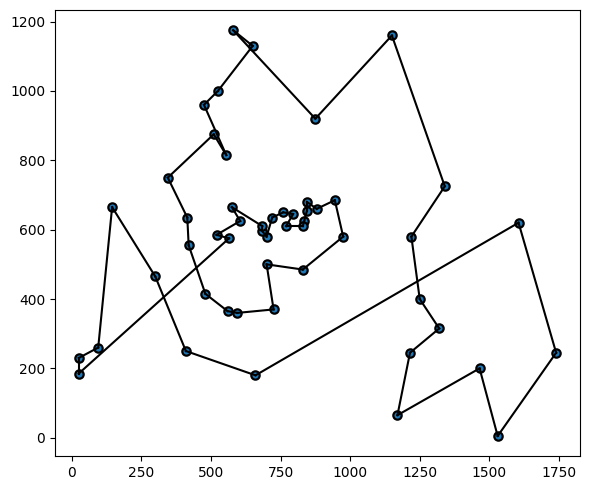

In [7]:
_, cost, paths_to_plot = nearest_neighbor(d, 0)
print(f'Cost: {cost}')
gif_generator(data, paths_to_plot, 'nearest_neighbor')

## Cheapest Insertion

In [8]:
# Cheapest neighbor for TSP:
def cheapest_insertion(distance_matrix, start):
    paths_to_plot = []
    path = [start]   # variable to save the path
    paths_to_plot.append(copy.deepcopy(path))
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool)  # to control which cities remain to visit   
    unvisited[start] = 0 
    
    # Find the closest city to the first city:
    next_ind = np.argmin(distance_matrix[path[-1]][unvisited]) 
    next_loc = np.arange(distance_matrix.shape[0])[unvisited][next_ind]
    path.append(next_loc) # city 2
    unvisited[next_loc] = 0
    paths_to_plot.append(copy.deepcopy(path))
    
    cost = distance_matrix[start, next_loc]
    new_path = []
    while len(path) < distance_matrix.shape[0]:
        # Find the closest neighbor to the tour (min cik + ckj - cij)
        smaller = np.inf
        for k in range(distance_matrix.shape[0]):
            if not unvisited[k]:
                continue
            # Finding the city which the cost of insert (dik + dkj − dij ) is the cheapest one.
            for i in range(len(path)-1):
                d = distance_matrix[path[i]][k] + distance_matrix[k][path[i+1]] - distance_matrix[path[i]][path[i+1]]
                if d < smaller:
                    smaller = d
                    new_path = path[:i + 1] + [k] + path[i + 1:]
                    new_city = k
        unvisited[new_city] = 0
        path = new_path
        paths_to_plot.append(copy.deepcopy(path))
        # Updating the cost
        cost += smaller
    # Updating the cost to add the cost from the lasst city to the first one.
    path.append(start)
    paths_to_plot.append(copy.deepcopy(path))
    cost += distance_matrix[path[-2], path[-1]] 
    return path, cost, paths_to_plot

Cost: 9014.893160319041
fig size: 100.0 DPI, size in inches [6. 5.]


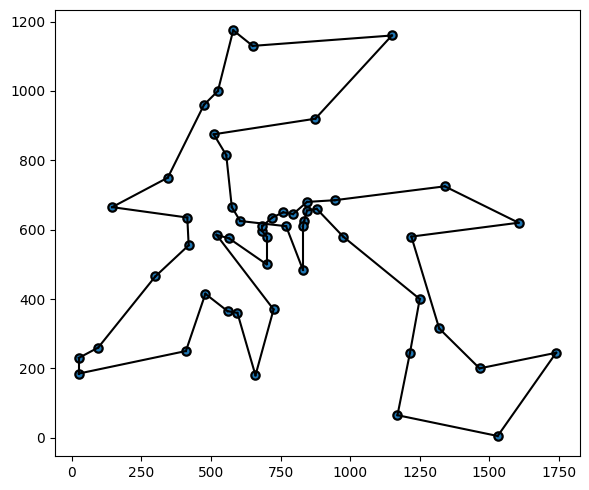

In [9]:
_, cost, paths_to_plot = cheapest_insertion(d, 0)
print(f'Cost: {cost}')
gif_generator(data, paths_to_plot, 'cheapest_insertion')

## Nearest Insertion

In [10]:
# Nearest insertion for TSP:
def nearest_insertion(distance_matrix, start):
    paths_to_plot = []
    # Step 1. Start with a sub-graph consisting of node i only
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool)   
    unvisited[start] = 0
    
    # Step 2. Find node r such that c_ir is minimal and form sub-tour i-r-i. 
    # initialize path with 2 first cities
    path = [start] # city 1
    paths_to_plot.append(copy.deepcopy(path))
    next_ind = np.argmin(distance_matrix[path[-1]][unvisited]) 
    next_loc = np.arange(distance_matrix.shape[0])[unvisited][next_ind] 
    path.append(next_loc) # city 2
    unvisited[next_loc] = 0
    paths_to_plot.append(copy.deepcopy(path))
    
    while len(path) < distance_matrix.shape[0]:
        smaller = np.inf
        # Step 3. (Selection step) Given a sub-tour, find node r not 
        # in the sub-tour closest to any node j in the sub-tour; i.e. with minimal c_rj 
        for i in range(len(path)):                
            idx = np.argmin(distance_matrix[path[i]][unvisited])
            min_distance = distance_matrix[path[i]][unvisited][idx]
            if min_distance < smaller:
                smaller_idx = np.arange(distance_matrix.shape[0])[unvisited][idx]
                smaller = min_distance
        
        unvisited[smaller_idx] = 0 
        insertion_cost = np.inf
        path.append(path[0])
        # Step 4. (Insertion step) Find the arc (i, j) in the sub-tour
        # which minimizes c_ir + c_rj - c_ij . Insert r between i and j. 
        for i in range(len(path)-1):
            new_insertion_cost = distance_matrix[path[i], smaller_idx] + distance_matrix[path[i+1], smaller_idx] - distance_matrix[path[i], path[i+1]]  
            if new_insertion_cost < insertion_cost:
                insertion_cost = new_insertion_cost
                insertion_idx = i
        path.insert(insertion_idx+1, smaller_idx)
        path = path[:-1]
        paths_to_plot.append(copy.deepcopy(path))
        #Step 5. If all the nodes are added to the tour, stop. Else go to step 3  
    # Calculating the cost
    path.append(path[0])
    paths_to_plot.append(copy.deepcopy(path))
    cost = 0 
    for i in range(len(path)-1):
        cost += distance_matrix[path[i], path[i+1]]
    return path, cost, paths_to_plot

Cost: 9004.920095060093
fig size: 100.0 DPI, size in inches [6. 5.]


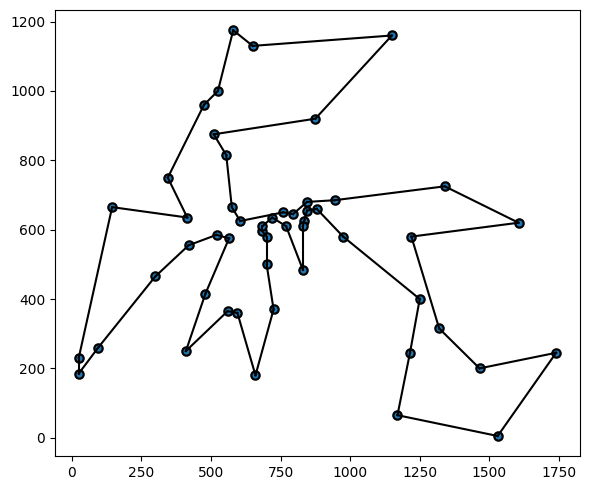

In [11]:
_, cost, paths_to_plot = nearest_insertion(d, 0)
print(f'Cost: {cost}')
gif_generator(data, paths_to_plot, 'nearest_insertion')

## Farthest Insertion

Para esse algoritmo, durante a pesquisa 2 formulações diferentes foram encontradas:
  
  - 1) Esse algoritmo começa com uma cidade e a conecta com a cidade mais distante dela. Em seguida, ele encontra repetidamente a cidade que ainda não está na rota e que está mais  distante do caminho já visitado e a coloca entre as duas cidades que permitem que a rota resultante seja a mais curta possível.
  
  - 2) Esse algoritmo começa com uma cidade e a conecta com a cidade mais distante dela. Em seguida, ele encontra repetidamente a cidade que ainda não está na rota e que está mais  distante possível de uma cidade já visitada e a coloca entre as duas cidades que permitem que a rota resultante seja a mais curta possível.

In [12]:
# Farthest insertion for TSP:
def farthest_insertion1(distance_matrix, start):
    cost=0
    # Step 1. Start with a sub-graph consisting of node i only
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool)   
    unvisited[start] = 0
    paths_to_plot = []
    # Step 2. Find node r such that c_ir is maximal and form sub-tour i-r-i. 
    # initialize path with 2 first cities
    path = [start] # city 1
    paths_to_plot.append(copy.deepcopy(path))
    next_ind = np.argmax(distance_matrix[path[-1]][unvisited]) 
    next_loc = np.arange(distance_matrix.shape[0])[unvisited][next_ind] 
    path.append(next_loc) # city 2
    paths_to_plot.append(copy.deepcopy(path))
    unvisited[next_loc] = 0
    while len(path) < distance_matrix.shape[0]:
        tour_distances = {}
        # Step 3. (Selection step) Given a sub-tour, find a
        # node not in the sub-tour farthest to the sub-tour;  
        for i in range(distance_matrix.shape[0]):
            if not unvisited[i]:
                continue
            distances = []
            for j in range(len(path)):  
                distances.append(distance_matrix[path[j], i])
            tour_distances[i] = min(distances) 
        larger_idx = max(tour_distances, key=tour_distances.get)
        unvisited[larger_idx] = 0
        insertion_cost = np.inf
        path.append(path[0])
        # Step 4. (Insertion step) Find the arc (i, j) in the sub-tour
        # which minimizes c_ir + c_rj - c_ij . Insert r between i and j. 
        for i in range(len(path)-1):
            new_insertion_cost = distance_matrix[path[i], larger_idx] + distance_matrix[larger_idx, path[i+1]] - distance_matrix[path[i], path[i+1]]  
            if new_insertion_cost < insertion_cost:
                insertion_cost = new_insertion_cost
                insertion_idx = i
        path.insert(insertion_idx+1, larger_idx)
        path = path[:-1]
        paths_to_plot.append(copy.deepcopy(path))
        #Step 5. If all the nodes are added to the tour, stop. Else go to step 3 
    # Calculating the cost
    path.append(path[0])
    paths_to_plot.append(copy.deepcopy(path))
    for i in range(len(path)-1):
        cost += distance_matrix[path[i], path[i+1]]   
    return path, cost, paths_to_plot

Cost: 8308.602406210206
fig size: 100.0 DPI, size in inches [6. 5.]


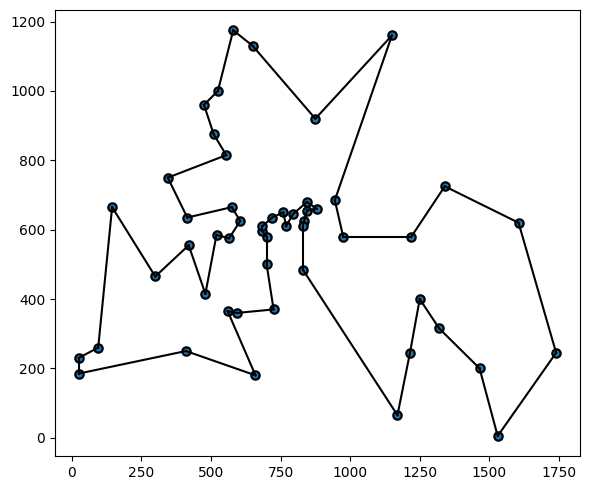

In [13]:
_, cost, paths_to_plot = farthest_insertion1(d, 0)
print(f'Cost: {cost}')
gif_generator(data, paths_to_plot, 'farthest_insertion1')

In [14]:
# Farthest insertion for TSP:
def farthest_insertion2(distance_matrix, start):
    paths_to_plot = []
    cost=0
    # Step 1. Start with a sub-graph consisting of node i only
    unvisited = np.ones(distance_matrix.shape[0], dtype=bool)   
    unvisited[start] = 0
    
    # Step 2. Find node r such that c_ir is maximal and form sub-tour i-r-i. 
    # initialize path with 2 first cities
    path = [start] # city 1
    paths_to_plot.append(copy.deepcopy(path))
    next_ind = np.argmax(distance_matrix[path[-1]][unvisited]) 
    next_loc = np.arange(distance_matrix.shape[0])[unvisited][next_ind] 
    path.append(next_loc) # city 2
    unvisited[next_loc] = 0
    paths_to_plot.append(copy.deepcopy(path))
    while len(path) < distance_matrix.shape[0]:
        larger = 0
        # Step 3. (Selection step) Given a sub-tour, find node r not 
        # in the sub-tour cfarthest to any node j in the sub-tour; i.e. with maximal c_rj 
        for i in range(len(path)):                
            idx = np.argmax(distance_matrix[path[i]][unvisited])
            max_distance = distance_matrix[path[i]][unvisited][idx]
            if max_distance > larger:
                larger_idx = np.arange(distance_matrix.shape[0])[unvisited][idx]
                larger = max_distance
        
        unvisited[larger_idx] = 0
        insertion_cost = np.inf
        path.append(path[0])
        # Step 4. (Insertion step) Find the arc (i, j) in the sub-tour
        # which minimizes c_ir + c_rj - c_ij . Insert r between i and j. 
        for i in range(len(path)-1):
            new_insertion_cost = distance_matrix[path[i], larger_idx] + distance_matrix[larger_idx, path[i+1]] - distance_matrix[path[i], path[i+1]]  
            if new_insertion_cost < insertion_cost:
                insertion_cost = new_insertion_cost
                insertion_idx = i
        path.insert(insertion_idx+1, larger_idx)
        path = path[:-1]
        paths_to_plot.append(copy.deepcopy(path))
        #Step 5. If all the nodes are added to the tour, stop. Else go to step 3 
    # Calculating the cost
    path.append(path[0])
    paths_to_plot.append(copy.deepcopy(path))
    for i in range(len(path)-1):
        cost += distance_matrix[path[i], path[i+1]]
    return path, cost, paths_to_plot

Cost: 8262.014938300117
fig size: 100.0 DPI, size in inches [6. 5.]


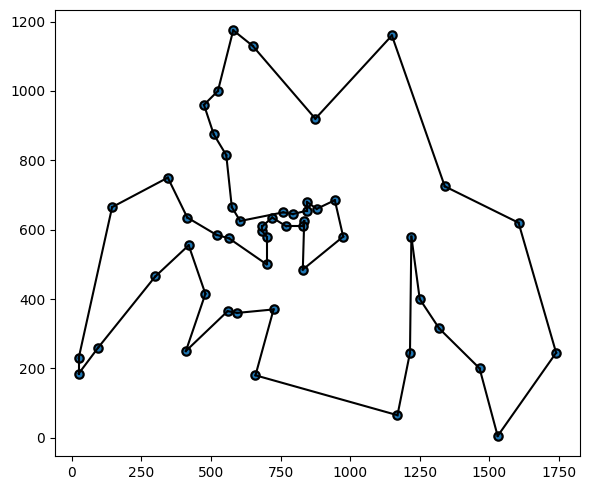

In [15]:
_, cost, paths_to_plot = farthest_insertion2(d, 0)
print(f'Cost: {cost}')
gif_generator(data, paths_to_plot, 'farthest_insertion2')